## Create a Learner for inference

In [ ]:
from fastai.gen_doc.nbdoc import *

In this tutorial, we'll see how the same API allows you to create an empty [`DataBunch`](/basic_data.html#DataBunch) for a [`Learner`](/basic_train.html#Learner) at inference time (once you have trained your model) and how to call the `predict` method to get the predictions on a single item.

In [ ]:
jekyll_note("""As usual, this page is generated from a notebook that you can find in the <code>docs_src</code> folder of the
<a href="https://github.com/fastai/fastai">fastai repo</a>. We use the saved models from <a href="/tutorial.data.html">this tutorial</a> to
have this notebook run quickly.""")

<div markdown="span" class="alert alert-info" role="alert"><i class="fa fa-info-circle"></i> <b>Note: </b>As usual, this page is generated from a notebook that you can find in the <code>docs_src</code> folder of the
<a href="https://github.com/fastai/fastai">fastai repo</a>. We use the saved models from <a href="/tutorial.data.html">this tutorial</a> to
have this notebook run quickly.</div>

## Vision

To quickly get acces to all the vision functionality inside fastai, we use the usual import statements.

In [ ]:
from fastai.vision import *

### A classification problem

Let's begin with our sample of the MNIST dataset.

In [ ]:
mnist = untar_data(URLs.MNIST_TINY)
tfms = get_transforms(do_flip=False)

It's set up with an imagenet structure so we use it to split our training and validation set, then labelling.

In [ ]:
data = (ImageList.from_folder(mnist)
        .split_by_folder()          
        .label_from_folder()
        .add_test_folder('test')
        .transform(tfms, size=32)
        .databunch()
        .normalize(imagenet_stats)) 

Now that our data has been properly set up, we can train a model. We already did in the [look at your data tutorial](/tutorial.data.html) so we'll just load our saved results here.

In [ ]:
learn = cnn_learner(data, models.resnet18).load('mini_train')

Once everything is ready for inference, we just have to call `learn.export` to save all the information of our [`Learner`](/basic_train.html#Learner) object for inference: the stuff we need in the [`DataBunch`](/basic_data.html#DataBunch) (transforms, classes, normalization...), the model with its weights and all the callbacks our [`Learner`](/basic_train.html#Learner) was using. Everything will be in a file named `export.pkl` in the folder `learn.path`. If you deploy your model on a different machine, this is the file you'll need to copy.

In [ ]:
learn.export()

To create the [`Learner`](/basic_train.html#Learner) for inference, you'll need to use the [`load_learner`](/basic_train.html#load_learner) function. Note that you don't have to specify anything: it remembers the classes, the transforms you used or the normalization in the data, the model, its weigths... The only argument needed is the folder where the 'export.pkl' file is.

In [ ]:
learn = load_learner(mnist)

You can now get the predictions on any image via `learn.predict`.

In [ ]:
img = data.train_ds[0][0]
learn.predict(img)

(Category 7, tensor(1), tensor([0.0256, 0.9744]))

It returns a tuple of three things: the object predicted (with the class in this instance), the underlying data (here the corresponding index) and the raw probabilities. You can also do inference on a larger set of data by adding a *test set*. This is done by passing an [`ItemList`](/data_block.html#ItemList) to [`load_learner`](/basic_train.html#load_learner).

In [ ]:
learn = load_learner(mnist, test=ImageList.from_folder(mnist/'test'))

In [ ]:
preds,y = learn.get_preds(ds_type=DatasetType.Test)
preds[:5]

tensor([[9.9584e-01, 4.1577e-03],
        [2.1839e-03, 9.9782e-01],
        [9.1030e-01, 8.9699e-02],
        [1.5733e-04, 9.9984e-01],
        [9.9992e-01, 7.7091e-05]])

### A multi-label problem

Now let's try these on the planet dataset, which is a little bit different in the sense that each image can have multiple tags (and not just one label).

In [ ]:
planet = untar_data(URLs.PLANET_TINY)
planet_tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

Here each images is labelled in a file named `labels.csv`. We have to add [`train`](/train.html#train) as a prefix to the filenames, `.jpg` as a suffix and indicate that the labels are separated by spaces.

In [ ]:
data = (ImageList.from_csv(planet, 'labels.csv', folder='train', suffix='.jpg')
        .split_by_rand_pct()
        .label_from_df(label_delim=' ')
        .transform(planet_tfms, size=128)
        .databunch()
        .normalize(imagenet_stats))

Again, we load the model we saved in [look at your data tutorial](/tutorial.data.html).

In [ ]:
learn = cnn_learner(data, models.resnet18).load('mini_train')

Then we can export it before loading it for inference.

In [ ]:
learn.export()

In [ ]:
learn = load_learner(planet)

And we get the predictions on any image via `learn.predict`.

In [ ]:
img = data.train_ds[0][0]
learn.predict(img)

(MultiCategory artisinal_mine;cloudy;cultivation;haze;primary;selective_logging,
 tensor([0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0.]),
 tensor([0.1527, 0.5516, 0.4432, 0.4352, 0.4839, 0.5042, 0.5634, 0.2602, 0.5044,
         0.4586, 0.5640, 0.2044, 0.5077, 0.3840]))

Here we can specify a particular threshold to consider the predictions to be correct or not. The default is `0.5`, but we can change it.

In [ ]:
learn.predict(img, thresh=0.3)

(MultiCategory artisinal_mine;bare_ground;blooming;clear;cloudy;cultivation;haze;partly_cloudy;primary;selective_logging;water,
 tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]),
 tensor([0.1527, 0.5516, 0.4432, 0.4352, 0.4839, 0.5042, 0.5634, 0.2602, 0.5044,
         0.4586, 0.5640, 0.2044, 0.5077, 0.3840]))

### A regression example

For the next example, we are going to use the [BIWI head pose](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db) dataset. On pictures of persons, we have to find the center of their face. For the fastai docs, we have built a small subsample of the dataset (200 images) and prepared a dictionary for the correspondance filename to center.

In [ ]:
biwi = untar_data(URLs.BIWI_SAMPLE)
fn2ctr = pickle.load(open(biwi/'centers.pkl', 'rb'))

To grab our data, we use this dictionary to label our items. We also use the [`PointsItemList`](/vision.data.html#PointsItemList) class to have the targets be of type [`ImagePoints`](/vision.image.html#ImagePoints) (which will make sure the data augmentation is properly applied to them). When calling [`transform`](/tabular.transform.html#tabular.transform) we make sure to set `tfm_y=True`.

In [ ]:
data = (PointsItemList.from_folder(biwi)
        .split_by_rand_pct(seed=42)
        .label_from_func(lambda o:fn2ctr[o.name])
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch()
        .normalize(imagenet_stats))

As before, the road to inference is pretty straightforward: load the model we trained before, export the [`Learner`](/basic_train.html#Learner) then load it for production.

In [ ]:
learn = cnn_learner(data, models.resnet18, lin_ftrs=[100], ps=0.05).load('mini_train');

In [ ]:
learn.export()

In [ ]:
learn = load_learner(biwi)

And now we can a prediction on an image.

In [ ]:
img = data.valid_ds[0][0]
learn.predict(img)

(ImagePoints (120, 160),
 tensor([[-1.2336e-03, -2.0357e+00]]),
 tensor([-1.2336e-03, -2.0357e+00]))

To visualize the predictions, we can use the [`Image.show`](/vision.image.html#Image.show) method.

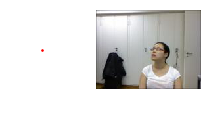

In [ ]:
img.show(y=learn.predict(img)[0])

### A segmentation example

Now we are going to look at the [camvid dataset](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/) (at least a small sample of it), where we have to predict the class of each pixel in an image. Each image in the 'images' subfolder as an equivalent in 'labels' that is its segmentations mask.

In [ ]:
camvid = untar_data(URLs.CAMVID_TINY)
path_lbl = camvid/'labels'
path_img = camvid/'images'

We read the classes in 'codes.txt' and the function maps each image filename with its corresponding mask filename.

In [ ]:
codes = np.loadtxt(camvid/'codes.txt', dtype=str)
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

The data block API allows us to uickly get everything in a [`DataBunch`](/basic_data.html#DataBunch) and then we can have a look with `show_batch`.

In [ ]:
data = (SegmentationItemList.from_folder(path_img)
        .split_by_rand_pct()
        .label_from_func(get_y_fn, classes=codes)
        .transform(get_transforms(), tfm_y=True, size=128)
        .databunch(bs=16, path=camvid)
        .normalize(imagenet_stats))

As before, we load our model, export the [`Learner`](/basic_train.html#Learner) then create a new one with [`load_learner`](/basic_train.html#load_learner).

In [ ]:
learn = unet_learner(data, models.resnet18).load('mini_train');
learn.export()

In [ ]:
learn = load_learner(camvid)

And now we can a prediction on an image.

In [ ]:
img = data.train_ds[0][0]
learn.predict(img);

To visualize the predictions, we can use the [`Image.show`](/vision.image.html#Image.show) method.

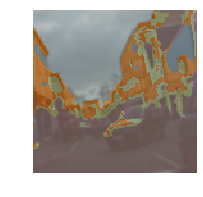

In [ ]:
img.show(y=learn.predict(img)[0])

## Text

Next application is text, so let's start by importing everything we'll need.

In [ ]:
from fastai.text import *

### Language modelling

First let's look a how to get a language model ready for inference. Since we'll load the model trained in the [visualize data tutorial](/tutorial.data.html), we load the [`DataBunch`](/basic_data.html#DataBunch) used there.

In [ ]:
imdb = untar_data(URLs.IMDB_SAMPLE)

In [ ]:
data_lm = load_data(imdb)

Like in vision, we just have to type `learn.export()` after loading our pretrained model to save all the information inside the [`Learner`](/basic_train.html#Learner) we'll need. In this case, this includes all the vocabulary we created. The only difference is that we will specify a filename, since we have several model in the same path (language model and classifier).

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=False).load('mini_train_lm', with_opt=False);

In [ ]:
learn.export(fname = 'export_lm.pkl')

Now let's define our inference learner.

In [ ]:
learn = load_learner(imdb, fname = 'export_lm.pkl')

Then we can predict with the usual method, here we can specify how many words we want the model to predict.

In [ ]:
learn.predict('This is a simple test of', n_words=20)

'This is a simple test of the new standards surrounding 1 / 10 performances on a lightweight road . This study contained other drives'

You can also use beam search to generate text.

In [ ]:
learn.beam_search('This is a simple test of', n_words=20, beam_sz=200)

'This is a simple test of the quality of the English - language version of the English language . \n \n  The English'

### Classification

Now let's see a classification example. We have to use the same vocabulary as for the language model if we want to be able to use the encoder we saved.

In [ ]:
data_clas = (TextList.from_csv(imdb, 'texts.csv', cols='text', vocab=data_lm.vocab)
                   .split_from_df(col='is_valid')
                   .label_from_df(cols='label')
                   .databunch(bs=42))

Again we export the [`Learner`](/basic_train.html#Learner) where we load our pretrained model.

In [ ]:
learn = text_classifier_learner(data_clas, AWD_LSTM, pretrained=False).load('mini_train_clas', with_opt=False);
learn.export(fname = 'export_clas.pkl')

Now let's use [`load_learner`](/basic_train.html#load_learner).

In [ ]:
learn = load_learner(imdb, fname = 'export_clas.pkl')

Then we can predict with the usual method.

In [ ]:
learn.predict('I really loved that movie!')

(Category negative, tensor(0), tensor([0.5082, 0.4918]))

## Tabular

Last application brings us to tabular data. First let's import everything we'll need.

In [ ]:
from fastai.tabular import *

We'll use a sample of the [adult dataset](https://archive.ics.uci.edu/ml/datasets/adult) here. Once we read the csv file, we'll need to specify the dependant variable, the categorical variables, the continuous variables and the processors we want to use.

In [ ]:
adult = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(adult/'adult.csv')
dep_var = 'salary'
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
cont_names = ['education-num', 'hours-per-week', 'age', 'capital-loss', 'fnlwgt', 'capital-gain']
procs = [FillMissing, Categorify, Normalize]

Then we can use the data block API to grab everything together.

In [ ]:
data = (TabularList.from_df(df, path=adult, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idx=range(800,1000))
                           .label_from_df(cols=dep_var)
                           .databunch())

We define a [`Learner`](/basic_train.html#Learner) object that we fit and then save the model.

In [ ]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy)
learn.fit(1, 1e-2)
learn.save('mini_train')

epoch,train_loss,valid_loss,accuracy
1,0.328325,0.367515,0.845000


As in the other applications, we just have to type `learn.export()` to save everything we'll need for inference (here it includes the inner state of each processor).

In [ ]:
learn.export()

Then we create a [`Learner`](/basic_train.html#Learner) for inference like before.

In [ ]:
learn = load_learner(adult)

And we can predict on a row of dataframe that has the right `cat_names` and `cont_names`.

In [ ]:
learn.predict(df.iloc[0])

(Category >=50k, tensor(1), tensor([0.3528, 0.6472]))